# Import

In [1]:
import os
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import shutil

In [2]:
import windows_utils_hf as util
import helpers

In [3]:
from sklearn import model_selection, metrics

import torch
import torchvision
from torchvision.transforms import v2
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import ReduceLROnPlateau
from efficientnet_pytorch import EfficientNet
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score
from torch.utils.data import DataLoader
from tqdm.auto import tqdm

from PIL import Image
import re
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

In [4]:
# Import utility functions
from cjm_pandas_utils.core import markdown_to_pandas
from cjm_pil_utils.core import resize_img
from cjm_pytorch_utils.core import set_seed, pil_to_tensor, tensor_to_pil, get_torch_device, denorm_img_tensor

# Import HuggingFace Datasets dependencies
from datasets import load_dataset

from torchvision.transforms import v2
from torchvision.io import read_image

# Load Data

In [5]:
repo_fp = Path('../data/')
noh_fp = repo_fp / 'NOH'

## NOH Data

In [6]:
noh_data = pd.read_csv('../metadata/NOH_image_dataset_3c.csv', index_col=0)
noh_data

,data,patient_id,img_id,label,dataset,img_path,filename,new_img_path,new_label
0,NOH,122,NOH_122,4,train,/content/drive/MyDrive/Colab Notebooks/AI4Thyr...,IMG_20230228_082014.jpg,processed_img/NOH_122/IMG_20230228_082014.jpg,2
1,NOH,122,NOH_122,4,train,/content/drive/MyDrive/Colab Notebooks/AI4Thyr...,IMG_20230228_082225.jpg,processed_img/NOH_122/IMG_20230228_082225.jpg,2
2,NOH,122,NOH_122,4,train,/content/drive/MyDrive/Colab Notebooks/AI4Thyr...,IMG_20230228_082229.jpg,processed_img/NOH_122/IMG_20230228_082229.jpg,2
3,NOH,122,NOH_122,4,train,/content/drive/MyDrive/Colab Notebooks/AI4Thyr...,IMG_20230228_081641.jpg,processed_img/NOH_122/IMG_20230228_081641.jpg,2
4,NOH,122,NOH_122,4,train,/content/drive/MyDrive/Colab Notebooks/AI4Thyr...,IMG_20230228_082243.jpg,processed_img/NOH_122/IMG_20230228_082243.jpg,2
...,...,...,...,...,...,...,...,...,...
2043,NOH,24,NOH_24,5,test,/content/drive/MyDrive/Colab Notebooks/AI4Thyr...,IMG_20230116_082639.jpg,processed_img/NOH_24/IMG_20230116_082639.jpg,2
2044,NOH,24,NOH_24,5,test,/content/drive/MyDrive/Colab Notebooks/AI4Thyr...,IMG_20230116_082508.jpg,processed_img/NOH_24/IMG_20230116_082508.jpg,2
2045,NOH,24,NOH_24,5,test,/content/drive/MyDrive/Colab Notebooks/AI4Thyr...,IMG_20230116_082541.jpg,processed_img/NOH_24/IMG_20230116_082541.jpg,2
2046,NOH,24,NOH_24,5,test,/content/drive/MyDrive/Colab Notebooks/AI4Thyr...,IMG_20230116_082615.jpg,processed_img/NOH_24/IMG_20230116_082615.jpg,2


In [7]:
noh_data['new_label'].value_counts().sort_index()

new_label
0      97
1     285
2    1666
Name: count, dtype: int64

# Stats

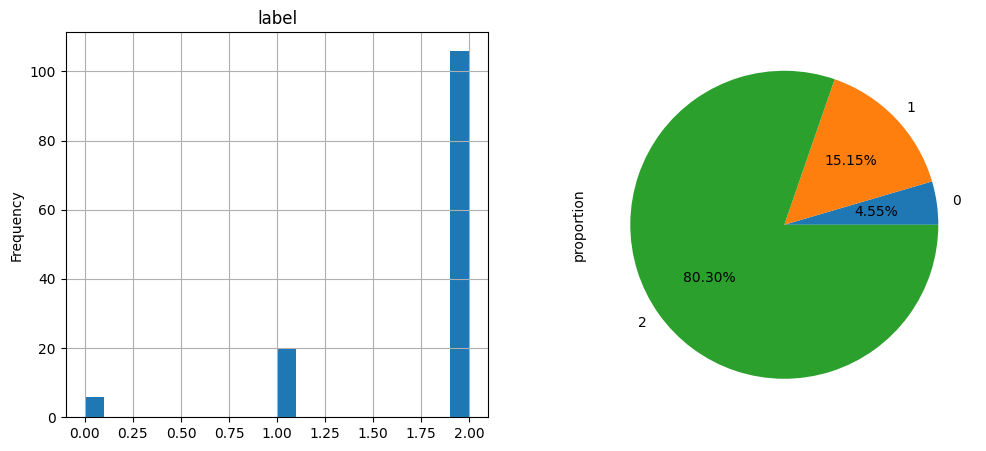

In [8]:
noh_sum = noh_data[['patient_id', 'new_label']].drop_duplicates()
fig, axs = plt.subplots(1,2,figsize=(12,5))
noh_sum['new_label'].plot(kind='hist', bins=20, title='label',ax=axs[0], grid=True)
noh_sum['new_label'].value_counts(dropna=False, normalize=True).fillna('NA').sort_index().plot(kind='pie', autopct='%.2f%%', ax=axs[1])
plt.gca().spines[['top', 'right',]].set_visible(False)

## Per patient

In [9]:
noh_data.groupby(['dataset','new_label'])['patient_id'].nunique().to_frame().reset_index().pivot_table(index='dataset', columns='new_label', values='patient_id').astype(int)

new_label,0,1,2
dataset,,,
test,2,5,32
train,2,9,45
val,2,6,29


## Per Image

In [10]:
noh_data.groupby(['dataset','new_label'])['filename'].nunique().to_frame().reset_index().pivot_table(index='dataset', columns='new_label', values='filename').astype(int)

new_label,0,1,2
dataset,,,
test,35,69,540
train,27,131,673
val,35,85,453


In [11]:
img_ds = noh_data[['new_img_path', 'new_label', 'dataset']]
img_ds = img_ds.rename(columns={'new_img_path': 'img_path'})
img_ds['img_path'] = img_ds['img_path'].apply(lambda x: os.path.join(str(repo_fp), x.replace('./','')))
img_ds

,img_path,new_label,dataset
0,../data/processed_img/NOH_122/IMG_20230228_082...,2,train
1,../data/processed_img/NOH_122/IMG_20230228_082...,2,train
2,../data/processed_img/NOH_122/IMG_20230228_082...,2,train
3,../data/processed_img/NOH_122/IMG_20230228_081...,2,train
4,../data/processed_img/NOH_122/IMG_20230228_082...,2,train
...,...,...,...
2043,../data/processed_img/NOH_24/IMG_20230116_0826...,2,test
2044,../data/processed_img/NOH_24/IMG_20230116_0825...,2,test
2045,../data/processed_img/NOH_24/IMG_20230116_0825...,2,test
2046,../data/processed_img/NOH_24/IMG_20230116_0826...,2,test


## Transform

In [12]:
plt.rcParams["savefig.bbox"] = 'tight'

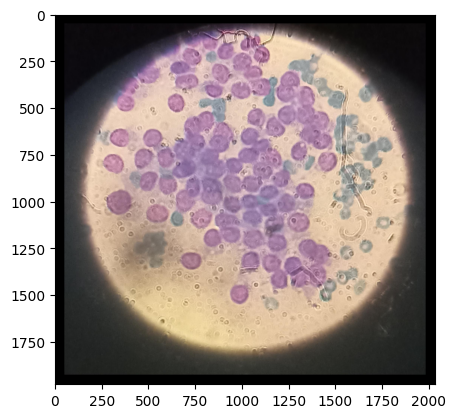

In [13]:
img_path = img_ds.iloc[0]['img_path']
# img = read_image(img_path)
img = Image.open(img_path)
plt.imshow(img)

In [14]:
# prompt: generate train and test transform


# Create transforms for train and test data
train_transform = v2.Compose([
    v2.ToImage(),
    v2.ToDtype(torch.float32, scale=True),
    v2.Resize(224, antialias=True),
    v2.RandomCrop(224),
    v2.RandomVerticalFlip(p=0.5),
    v2.RandomHorizontalFlip(p=0.5),
    # v2.AutoAugment(v2.AutoAugmentPolicy.CIFAR10), # [v2.AutoAugmentPolicy.CIFAR10, v2.AutoAugmentPolicy.IMAGENET, v2.AutoAugmentPolicy.SVHN]
    v2.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

test_transform = v2.Compose([
    v2.ToImage(),
    v2.ToDtype(torch.float32, scale=True),
    v2.Resize(224, antialias=True),
    v2.CenterCrop(size=224),
    v2.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

### Inspect train and test transform

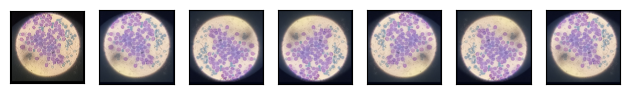

In [15]:
train_outs = [train_transform(img) for i in range(5)]
test_out = test_transform(img)
helpers.plot([img, test_out] + train_outs)

## Batch size

In [16]:
batch_size=16

# Dataset and DataLoader

In [17]:
# prompt: i need pytorch dataset that read from dataframe
class NOHThyroidDataset(torch.utils.data.Dataset):
    def __init__(self, dataframe, transform=None):
        self.dataframe = dataframe
        self.transform = transform

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        image_path = self.dataframe['img_path'][idx]
        label = self.dataframe['new_label'][idx]
        image = Image.open(image_path)
        if self.transform:
            image = self.transform(image)
        return image, label


In [18]:
train_df = img_ds[img_ds['dataset']=='train'].reset_index(drop=True)
val_df = img_ds[img_ds['dataset']=='val'].reset_index(drop=True)
test_df = img_ds[img_ds['dataset']=='test'].reset_index(drop=True)

In [19]:
trainset = NOHThyroidDataset(train_df, transform=train_transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=8)

In [20]:
valset = NOHThyroidDataset(val_df, transform=test_transform)
valoader = torch.utils.data.DataLoader(valset, batch_size=batch_size,
                                          shuffle=False, num_workers=8)

In [21]:
testset = NOHThyroidDataset(test_df, transform=test_transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                          shuffle=False, num_workers=8)

##  Inspect Image

In [22]:
norm_stats = ((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))

../data/processed_img/NOH_31/IMG_20230116_102328.jpg


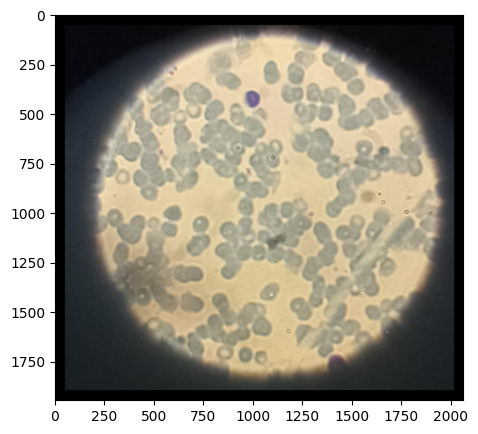

In [23]:
# Select a random item from the dataset
import numpy as np
item_path = np.random.choice(train_df['img_path'])
print(item_path)
sample_img = Image.open(item_path)
# Display the image
fig = plt.figure(figsize=(10,5))
plt.imshow(sample_img)
plt.show()

Feature batch shape: torch.Size([16, 3, 224, 224])
Labels batch shape: torch.Size([16])


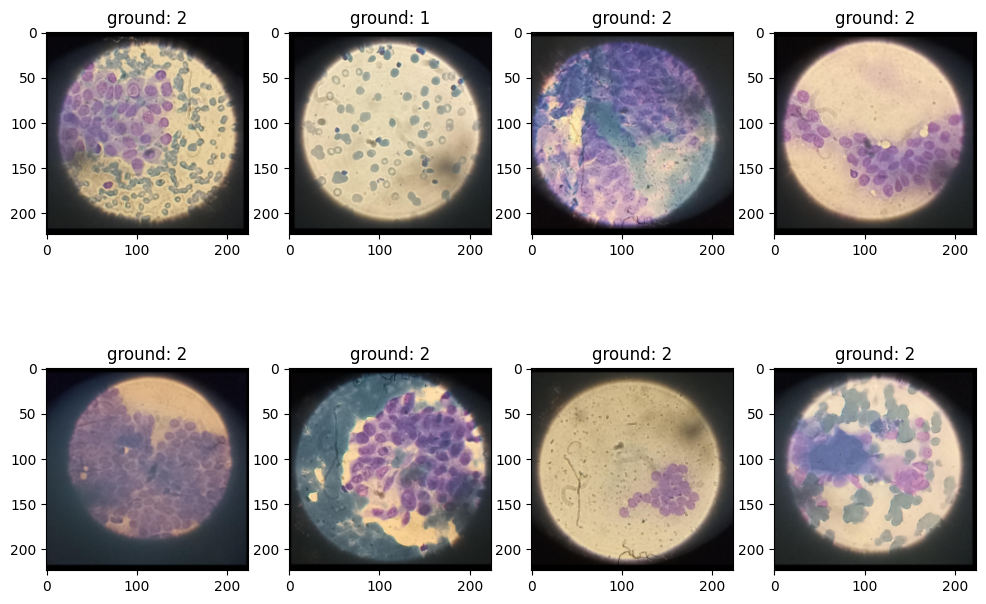

In [24]:
train_features, train_labels = next(iter(trainloader))
print(f"Feature batch shape: {train_features.size()}")
print(f"Labels batch shape: {train_labels.size()}")
indx = 0
f, axarr = plt.subplots(2, 4, figsize=(12, 8))
for r in range(0, 2):
  for c in range(0, 4):
    img = train_features[indx].squeeze()
    label = train_labels[indx]
    axarr[r, c].imshow(tensor_to_pil(denorm_img_tensor(img, *norm_stats)))
    axarr[r, c].set_title(f'ground: {label}')
    indx+=1
#tensor_to_pil(denorm_img_tensor(train_dataset[10][0], *norm_stats))

## Device and Tensorboard

In [25]:
if torch.cuda.is_available():
    # Get the number of available GPUs
    num_gpus = torch.cuda.device_count()

    print(f"Number of available GPUs: {num_gpus}")

    # List information about each GPU
    for i in range(num_gpus):
        gpu_info = torch.cuda.get_device_properties(i)
        print(f"GPU {i}: {gpu_info.name}")
        print(f"   Compute Capability: {gpu_info.major}.{gpu_info.minor}")
        print(f"   Total Memory: {gpu_info.total_memory / (1024 ** 3):.2f} GB\n")
else:
    print("No GPUs available.")


Number of available GPUs: 2
GPU 0: NVIDIA GeForce RTX 2080
   Compute Capability: 7.5
   Total Memory: 7.79 GB

GPU 1: NVIDIA GeForce RTX 2080
   Compute Capability: 7.5
   Total Memory: 7.79 GB



In [26]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [27]:
# prompt: use tensorboard to log
from torch.utils.tensorboard import SummaryWriter
writer = SummaryWriter('../runs/thyroid_NOH_3class')

2024-02-23 18:31:40.721710: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-02-23 18:31:40.721743: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-02-23 18:31:40.722847: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-02-23 18:31:40.728683: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-02-23 18:31:41.494186: W tensorflow/comp

# Load model

In [28]:
# prompt: train this trainloader using efficient-net model. this is classification problem
model = EfficientNet.from_pretrained('efficientnet-b0')

Loaded pretrained weights for efficientnet-b0


In [29]:
model._fc = nn.Linear(model._fc.in_features, train_df['new_label'].nunique())
model.to(device);

In [30]:
model._fc

Linear(in_features=1280, out_features=3, bias=True)

In [31]:
num_epochs = 10
best_val_acc = 0.0

# Criterion, Optimizer, Scheduler

In [32]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
scheduler = ReduceLROnPlateau(optimizer, 'min', factor=0.3, patience=3, verbose=True)

In [33]:
# AdamW optimizer; includes weight decay for regularization
# optimizer = torch.optim.AdamW(model.parameters(), lr=0.0001, eps=1e-5)

# Learning rate scheduler; adjusts the learning rate during training
# scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=0.001, total_steps=num_epochs*len(trainloader))

In [34]:
def evaluate_dataset(model, ds_loader):
    model.eval()
    loss = 0.0
    acc = 0.0
    for _, (data, target) in enumerate(tqdm(ds_loader)):
        data, target = data.to(device), target.to(device)
        output = model(data)
        loss = criterion(output, target)
        loss += loss.item()
        acc += accuracy_score(output.cpu().argmax(dim=1), target.cpu())
    loss /= len(testloader)
    acc /= len(testloader)
    print('Test Loss: {:.4f} \tTest Acc: {:.4f}'.format(loss, acc))
    return acc

# If exist model, then evaluate before write new

In [35]:
def run_predict_testset():
    test_features, test_labels = next(iter(testloader))
    # Make a prediction with the model
    class_names = [0,1,2]
    with torch.no_grad():
        preds = model(test_features.to(device))
        #print(preds)
        print(f"Feature batch shape: {test_features.size()}")
        print(f"Labels batch shape: {test_labels.size()}")
        indx = 0
        f, axarr = plt.subplots(3, 3, figsize=(12, 8))
        for r in range(0, 3):
            for c in range(0, 3):
                img_tensor = test_features[indx]
                label = class_names[test_labels[indx].numpy()]
                print('Label: ', label)
                # Scale the model predictions to add up to 1
                pred_scores = torch.softmax(preds[indx], dim=0)
                # Get the highest confidence score
                confidence_score = pred_scores.max()
                # Get the class index with the highest confidence score and convert it to the class name
                pred_class = class_names[torch.argmax(pred_scores)]
                print('Predicted: ', pred_class)
                axarr[r, c].imshow(tensor_to_pil(denorm_img_tensor(img_tensor, *norm_stats)))
                axarr[r, c].set_title(f"ground: {label}, pred: {pred_class}, conf: {confidence_score*100:.2f}%")
                indx+=1
        plt.tight_layout()
        plt.show()

In [36]:
baseline_model_path = '../model/noh_3class/efficientnet-b0-clf.pt'

  0%|          | 0/36 [00:00<?, ?it/s]

Test Loss: 0.0004 	Test Acc: 0.7790
Feature batch shape: torch.Size([16, 3, 224, 224])
Labels batch shape: torch.Size([16])
Label:  2
Predicted:  2
Label:  2
Predicted:  2
Label:  2
Predicted:  2
Label:  2
Predicted:  2
Label:  2
Predicted:  2
Label:  2
Predicted:  2
Label:  2
Predicted:  2
Label:  2
Predicted:  2
Label:  2
Predicted:  2


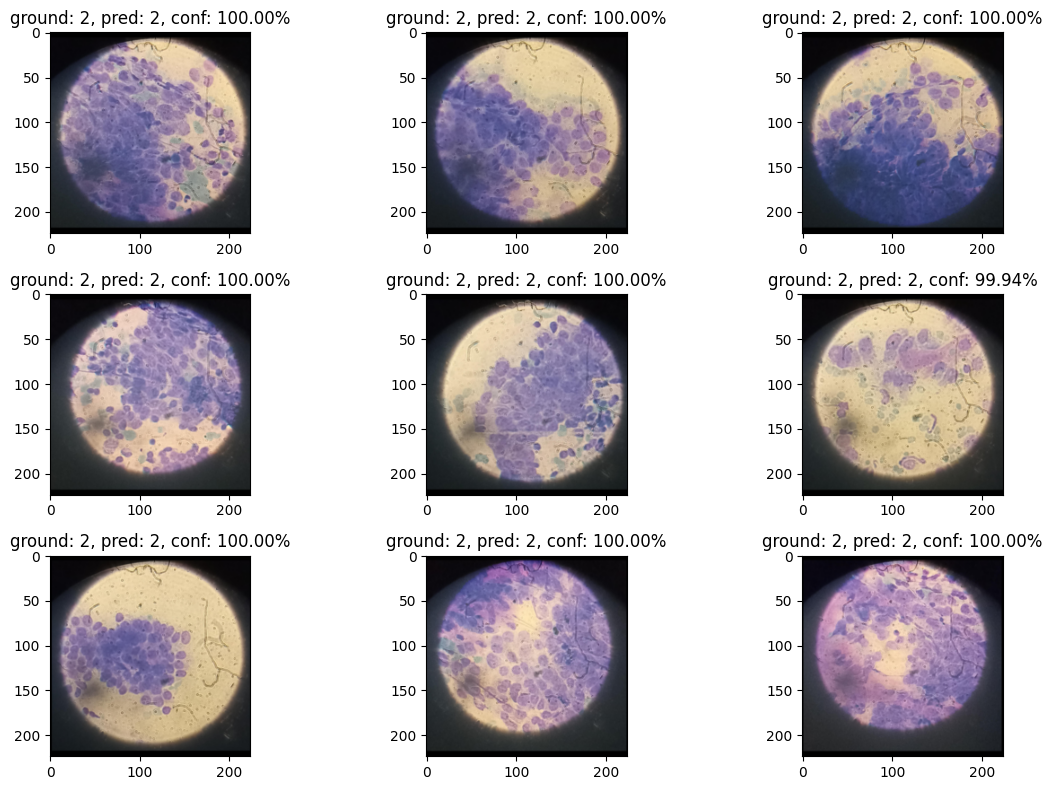

In [37]:
# reload model
model_fp = Path(baseline_model_path)
if model_fp.exists():
    model.load_state_dict(torch.load(str(model_fp), map_location=torch.device(device)))
    best_val_acc = evaluate_dataset(model, valoader)
    run_predict_testset()

In [38]:
best_val_acc

0.7789634146341463

# Train model

In [39]:
# for batch_idx, (data, target) in enumerate(tqdm(trainloader)):
#     data, target = data.to(device), target.to(device)

In [40]:
# for batch_idx, (data, target) in enumerate(tqdm(valoader)):
#     data, target = data.to(device), target.to(device)

In [41]:
# for batch_idx, (data, target) in enumerate(tqdm(testloader)):
#     data, target = data.to(device), target.to(device)

In [42]:
for epoch in range(num_epochs):
    model.train()
    train_loss = 0.0
    train_acc = 0.0
    for batch_idx, (data, target) in enumerate(tqdm(trainloader)):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
        train_acc += accuracy_score(output.cpu().argmax(dim=1), target.cpu())
    train_loss /= len(trainloader)
    train_acc /= len(trainloader)

    model.eval()
    val_loss = 0.0
    val_acc = 0.0
    for batch_idx, (data, target) in enumerate(tqdm(valoader)):
        data, target = data.to(device), target.to(device)
        output = model(data)
        loss = criterion(output, target)
        val_loss += loss.item()
        val_acc += accuracy_score(output.cpu().argmax(dim=1), target.cpu())
    val_loss /= len(valoader)
    val_acc /= len(valoader)

    scheduler.step(val_loss)

    print('Epoch: {} \tTrain Loss: {:.4f} \tTrain Acc: {:.4f} \tVal Loss: {:.4f} \tVal Acc: {:.4f}'.format(
        epoch, train_loss, train_acc, val_loss, val_acc))
    writer.add_scalar('Train/Loss', loss.item(), epoch * len(trainloader) + batch_idx)
    writer.add_scalar('Train/Accuracy', train_acc, epoch * len(trainloader) + batch_idx)
    writer.add_scalar('Validation/Loss', val_loss, epoch * len(valoader) + batch_idx)
    writer.add_scalar('Validation/Accuracy', val_acc, epoch * len(valoader) + batch_idx)

    if val_acc > best_val_acc:
        best_val_acc = val_acc
        test_acc = evaluate_dataset(model, testloader)
        print(f'Better result, val: {best_val_acc}, test: {test_acc}')
        torch.save(model.state_dict(), baseline_model_path)

  0%|          | 0/52 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

Epoch: 0 	Train Loss: 0.0482 	Train Acc: 0.9832 	Val Loss: 1.1041 	Val Acc: 0.8729


  0%|          | 0/41 [00:00<?, ?it/s]

Test Loss: 0.0000 	Test Acc: 0.8598
Better result, val: 0.8728632478632479, test: 0.8597560975609756


  0%|          | 0/52 [00:00<?, ?it/s]

  0%|          | 0/36 [02:00<?, ?it/s]

Epoch: 1 	Train Loss: 0.0439 	Train Acc: 0.9868 	Val Loss: 1.0031 	Val Acc: 0.8052


  0%|          | 0/52 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

Epoch: 2 	Train Loss: 0.0333 	Train Acc: 0.9916 	Val Loss: 1.3295 	Val Acc: 0.8231


  0%|          | 0/52 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

Epoch: 3 	Train Loss: 0.0267 	Train Acc: 0.9916 	Val Loss: 0.8743 	Val Acc: 0.8347


  0%|          | 0/52 [00:00<?, ?it/s]

  0%|          | 0/36 [03:20<?, ?it/s]

Epoch: 4 	Train Loss: 0.0505 	Train Acc: 0.9856 	Val Loss: 1.0092 	Val Acc: 0.8312


  0%|          | 0/52 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

Epoch: 5 	Train Loss: 0.0239 	Train Acc: 0.9928 	Val Loss: 0.9202 	Val Acc: 0.8329


  0%|          | 0/52 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

Epoch: 6 	Train Loss: 0.0455 	Train Acc: 0.9868 	Val Loss: 1.1074 	Val Acc: 0.8184


  0%|          | 0/52 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

Epoch 00008: reducing learning rate of group 0 to 3.0000e-04.
Epoch: 7 	Train Loss: 0.0380 	Train Acc: 0.9892 	Val Loss: 1.3537 	Val Acc: 0.8456


  0%|          | 0/52 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

Epoch: 8 	Train Loss: 0.0193 	Train Acc: 0.9916 	Val Loss: 0.9292 	Val Acc: 0.8638


  0%|          | 0/52 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

Epoch: 9 	Train Loss: 0.0100 	Train Acc: 0.9964 	Val Loss: 0.9727 	Val Acc: 0.8300


In [43]:
best_val_acc

0.8728632478632479

# Evaluate

In [44]:
evaluate_dataset(model, testloader)

  0%|          | 0/41 [00:00<?, ?it/s]

Test Loss: 0.0000 	Test Acc: 0.7988


0.7987804878048781